In [42]:
# Import necessary libraries for data handling, image processing, and model building
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add, SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

# Specify the path to the Air-Pollution-Image-Dataset-From-India-and-Nepal CSV files after extraction
Provide the file paths for the training, validation, and testing CSV files from the dataset.

In [43]:
# Define file paths for the dataset CSV files
train_csv_file = 'Datasets/train_data.csv'
val_csv_file = 'Datasets/val_data.csv'
test_csv_file = 'Datasets/testing_data.csv'

In [44]:
# Implement Mixup augmentation to enhance model generalization
def apply_mixup(images, labels, alpha=0.2):
    batch_size = images.shape[0]
    lam = np.random.beta(alpha, alpha, batch_size)
    indices = np.random.permutation(batch_size)
    
    mixed_images = np.zeros_like(images)
    mixed_labels = np.zeros_like(labels)
    
    for i in range(batch_size):
        mixed_images[i] = lam[i] * images[i] + (1 - lam[i]) * images[indices[i]]
        mixed_labels[i] = lam[i] * labels[i] + (1 - lam[i]) * labels[indices[i]]
    
    return mixed_images, mixed_labels

# Create a custom Sequence class to apply Mixup to the data generator
class MixupSequence(Sequence):
    def __init__(self, generator, alpha=0.2):
        self.generator = generator
        self.alpha = alpha
        self.on_epoch_end()

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        mixed_images, mixed_labels = apply_mixup(images, labels, self.alpha)
        return mixed_images, mixed_labels

    def on_epoch_end(self):
        self.generator.on_epoch_end()

    def __getattr__(self, attr):
        return getattr(self.generator, attr)

In [45]:
# Read the training, validation, and testing CSV files
train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

# Compute class weights to balance the dataset
max_count = train_df['AQI_Class'].value_counts(normalize=True).max()
class_weights = {cls: max_count / count for cls, count in train_df['AQI_Class'].value_counts(normalize=True).items()}

# Define image normalization function using ImageNet statistics
def normalize(image):
    image = image.astype('float32') / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std
    return image

# Set the image directory path
path = 'Datasets/Images'

# Configure training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=normalize,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Configure validation and test data generators without augmentation
val_datagen = ImageDataGenerator(preprocessing_function=normalize)

# Create data generators for training, validation, and testing
train_generator = MixupSequence(
    train_datagen.flow_from_dataframe(
        train_df,
        directory='Datasets/Images',
        x_col='Filename',
        y_col='AQI_Class',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32
    ),
    alpha=0.1
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    directory='Datasets/Images',
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 7833 validated image filenames belonging to 6 classes.
Found 1959 validated image filenames belonging to 6 classes.
Found 2448 validated image filenames belonging to 6 classes.


# Build and train a model for AQI class image classification

In [46]:
# Define a helper function to create a separable convolution block with specified filters
def make_separable_conv_block(x, filters, kernel_size=3, strides=1, weight_decay=1e-4, initializer=HeNormal(seed=42)):
    x = SeparableConv2D(filters, kernel_size, strides=strides, padding='same', 
                        depthwise_initializer=initializer, 
                        pointwise_initializer=initializer, 
                        depthwise_regularizer=l2(weight_decay), 
                        pointwise_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Define a helper function to create an Xception entry flow block
def entry_flow_block(x, filters, strides=1, weight_decay=1e-4, initializer=HeNormal(seed=42)):
    # Residual connection
    residual = Conv2D(filters, 1, strides=strides if strides == 1 else 2, padding='same', 
                      kernel_initializer=initializer, 
                      kernel_regularizer=l2(weight_decay))(x)
    residual = BatchNormalization()(residual)

    # Separable convolution layers
    x = make_separable_conv_block(x, filters, strides=1, weight_decay=weight_decay, initializer=initializer)
    x = make_separable_conv_block(x, filters, strides=1, weight_decay=weight_decay, initializer=initializer)
    
    # Max pooling to match residual connection's downsampling
    if strides != 1:
        x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    # Add residual connection
    x = Add()([x, residual])
    return x

# Define a helper function to create an Xception middle flow block
def middle_flow_block(x, filters, weight_decay=1e-4, initializer=HeNormal(seed=42)):
    residual = x
    for _ in range(3):  # Reduced to 3 for simplicity and to match typical Xception implementation
        x = make_separable_conv_block(x, filters, weight_decay=weight_decay, initializer=initializer)
    x = Add()([x, residual])
    return x

# Define a helper function to create an Xception exit flow block
def exit_flow_block(x, filters, weight_decay=1e-4, initializer=HeNormal(seed=42)):
    residual = Conv2D(filters, 1, strides=2, padding='same', 
                      kernel_initializer=initializer, 
                      kernel_regularizer=l2(weight_decay))(x)
    residual = BatchNormalization()(residual)

    x = make_separable_conv_block(x, filters // 2, weight_decay=weight_decay, initializer=initializer)
    x = make_separable_conv_block(x, filters, weight_decay=weight_decay, initializer=initializer)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    x = Add()([x, residual])
    
    x = make_separable_conv_block(x, filters, weight_decay=weight_decay, initializer=initializer)
    x = make_separable_conv_block(x, filters * 2, weight_decay=weight_decay, initializer=initializer)
    return x

# Define the Xception architecture
def create_xception_model(input_shape=(224, 224, 3), num_classes=6, weight_decay=1e-4):
    initializer = HeNormal(seed=42)  # Use Kaiming (HeNormal) initialization
    
    # Define input layer
    inputs = Input(shape=input_shape)

    # Entry flow
    x = Conv2D(32, 3, strides=2, padding='same', 
               kernel_initializer=initializer, 
               kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, 3, padding='same', 
               kernel_initializer=initializer, 
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = entry_flow_block(x, 128, strides=2, weight_decay=weight_decay, initializer=initializer)
    x = entry_flow_block(x, 256, strides=2, weight_decay=weight_decay, initializer=initializer)
    x = entry_flow_block(x, 728, strides=2, weight_decay=weight_decay, initializer=initializer)

    # Middle flow
    for _ in range(8):  # Repeat middle flow block 8 times
        x = middle_flow_block(x, 728, weight_decay=weight_decay, initializer=initializer)

    # Exit flow
    x = exit_flow_block(x, 1024, weight_decay=weight_decay, initializer=initializer)

    # Global average pooling and fully connected layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer=initializer, kernel_regularizer=l2(weight_decay))(x)

    # Build and return the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

weight_decay = 1e-4  # Set weight decay for regularization
# Initialize the Xception model
model = create_xception_model(input_shape=(224, 224, 3), num_classes=6, weight_decay=weight_decay)

In [47]:
# Compile the model with optimizer, loss function, and metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

initial_learning_rate = 0.0001
optimizer = AdamW(learning_rate=initial_learning_rate, weight_decay=weight_decay)

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [48]:
# Train the model with callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

model.save_weights('xception_model.weights.h5')

/home/jason/Desktop/2025DLProgrammingFinalExam/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 68s 204ms/step - accuracy: 0.3925 - loss: 7.0821 - precision: 0.6350 - recall: 0.0915 - val_accuracy: 0.2338 - val_loss: 7.1271 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - accuracy: 0.5628 - loss: 6.4090 - precision: 0.7578 - recall: 0.2322 - val_accuracy: 0.3083 - val_loss: 6.8293 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.6165 - loss: 6.0298 - precision: 0.7717 - recall: 0.2750 - val_accuracy: 0.5824 - val_loss: 5.8313 - val_precision: 0.6600 - val_recall: 0.3885 - learning_rate: 1.0000e-04
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.6981 - loss: 5.6284 - precision: 0.8226 - recall: 0.3467 - val_accuracy: 0.7147 - val_loss: 5.3172 - val_precision: 0.7647 - val_recall: 0.6554 - learning_rate: 1.0000e-04
Epoch 5/100
245/

# plot your Training Accuracy and validation accuracy here

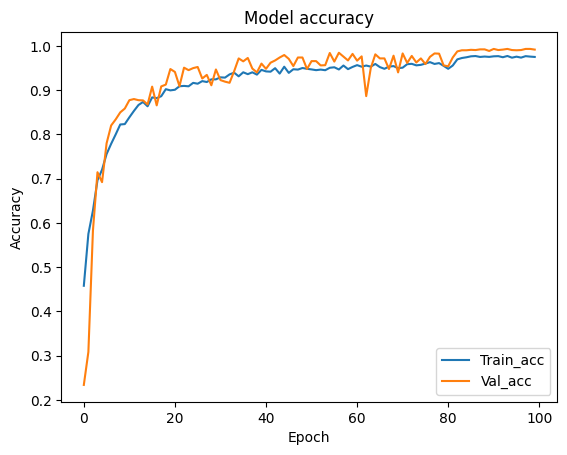

In [49]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.legend(['Train_acc', 'Val_acc'], loc='lower right')
plt.show()

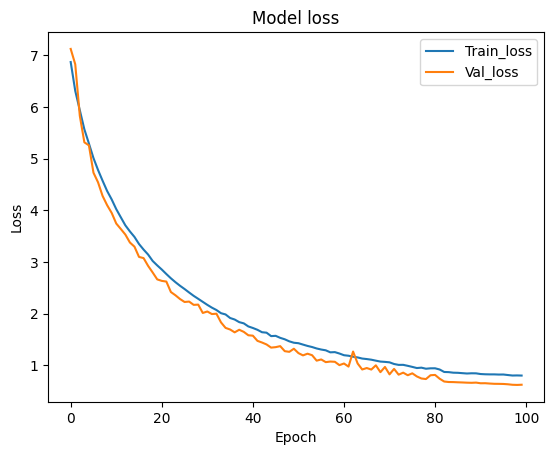

In [50]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_loss', 'Val_loss'], loc='upper right')
plt.show()

# Test your test data and save your result file in this format and upload your solution file on kaggle competition

In [51]:
test_probabilities = model.predict(test_generator)
test_filenames = test_generator.filenames
test_probabilities_df = pd.DataFrame(test_probabilities, columns=['a_Good', 'b_Moderate', 
                                                                  'c_Unhealthy_for_Sensitive_Groups', 'd_Unhealthy', 
                                                                  'e_Very_Unhealthy', 'f_Severe'])
test_probabilities_df.insert(0, 'Filename', test_filenames)
test_probabilities_df.to_csv('Outputs/xception_test_results.csv', index=False)


75/77 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

2025-06-20 01:12:57.818506: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1220', 4 bytes spill stores, 4 bytes spill loads

2025-06-20 01:12:58.091120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 40 bytes spill stores, 64 bytes spill loads

2025-06-20 01:12:58.116120: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1234', 76 bytes spill stores, 76 bytes spill loads

2025-06-20 01:12:58.165982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 608 bytes spill stores, 608 bytes spill loads

2025-06-20 01:12:58.240549: I external/l

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step


In [52]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions for the test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get the true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)

# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9990 - loss: 0.5893 - precision: 0.9990 - recall: 0.9987
Test Loss: 0.5933
Test Accuracy: 0.9980
Test Precision: 0.9980
Test Recall: 0.9975
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [53]:
# Calculate the F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = f1_score(y_true, y_pred, average='macro')

# Print the F1 scores for each class
for i, f1 in enumerate(f1_scores):
    print("Class {}: F1 Score = {:.4f}".format(i, f1))

# Print the average F1 score
print("Average F1 Score: {:.4f}".format(average_f1_score))
print()
print("Test Accuracy: {:.4f}".format(test_accuracy))

Class 0: F1 Score = 0.1230
Class 1: F1 Score = 0.1210
Class 2: F1 Score = 0.2320
Class 3: F1 Score = 0.1958
Class 4: F1 Score = 0.2114
Class 5: F1 Score = 0.1000
Average F1 Score: 0.1639

Test Accuracy: 0.9980


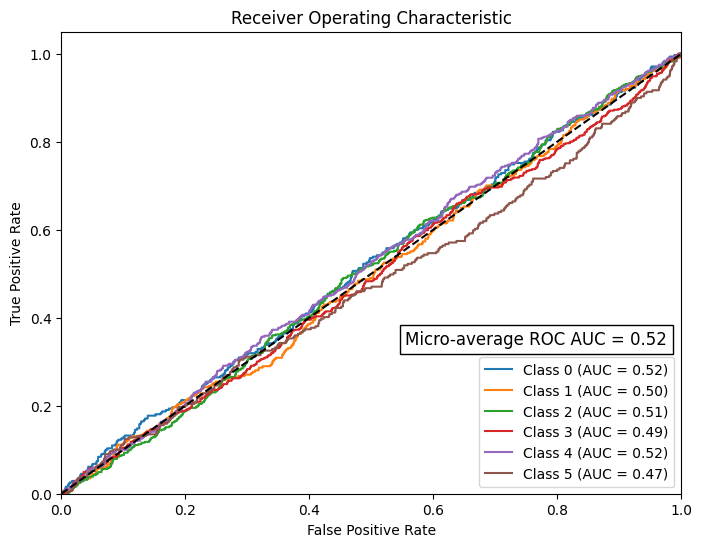

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

# Calculate the ROC AUC score for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_pred_prob, average='micro')

# Plot the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(test_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(test_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random chance curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Add micro-average ROC AUC score to the plot
plt.text(0.555, 0.34, 'Micro-average ROC AUC = %0.2f' % roc_auc_scores, fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

plt.show()


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Generate predictions for the training data
train_pred = model.predict(train_generator)
train_pred = np.argmax(train_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the validation data
val_pred = model.predict(val_generator)
val_pred = np.argmax(val_pred, axis=1)  # Convert predictions to class labels

# Generate predictions for the testing data
test_pred = model.predict(test_generator)
test_pred = np.argmax(test_pred, axis=1)  # Convert predictions to class labels

# Calculate overall MAE and RMSE
train_mae = mean_absolute_error(train_generator.classes, train_pred)
train_rmse = np.sqrt(mean_squared_error(train_generator.classes, train_pred))

val_mae = mean_absolute_error(val_generator.classes, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_generator.classes, val_pred))

test_mae = mean_absolute_error(test_generator.classes, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_generator.classes, test_pred))

print("Overall MAE - Training: {:.4f}".format(train_mae))
print("Overall RMSE - Training: {:.4f}".format(train_rmse))
print("Overall MAE - Validation: {:.4f}".format(val_mae))
print("Overall RMSE - Validation: {:.4f}".format(val_rmse))
print("Overall MAE - Testing: {:.4f}".format(test_mae))
print("Overall RMSE - Testing: {:.4f}".format(test_rmse))

244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

2025-06-20 01:13:47.343065: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 208 bytes spill stores, 228 bytes spill loads

2025-06-20 01:13:47.377367: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 488 bytes spill stores, 488 bytes spill loads

2025-06-20 01:13:47.378308: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227_0', 576 bytes spill stores, 1208 bytes spill loads

2025-06-20 01:13:47.445723: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1227', 740 bytes spill stores, 740 bytes spill loads

2025-06-20 01:13:47.456535: I

245/245 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Overall MAE - Training: 1.7442
Overall RMSE - Training: 2.1772
Overall MAE - Validation: 1.6856
Overall RMSE - Validation: 2.1315
Overall MAE - Testing: 1.7377
Overall RMSE - Testing: 2.1512


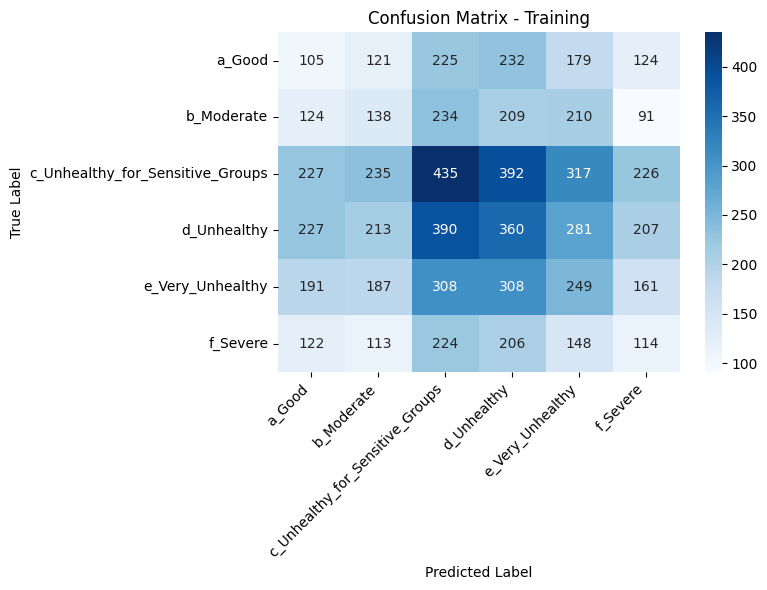

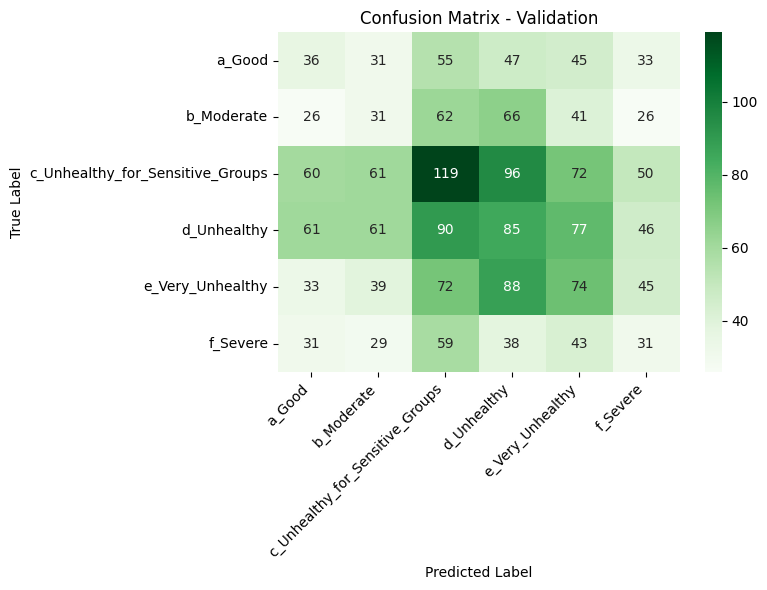

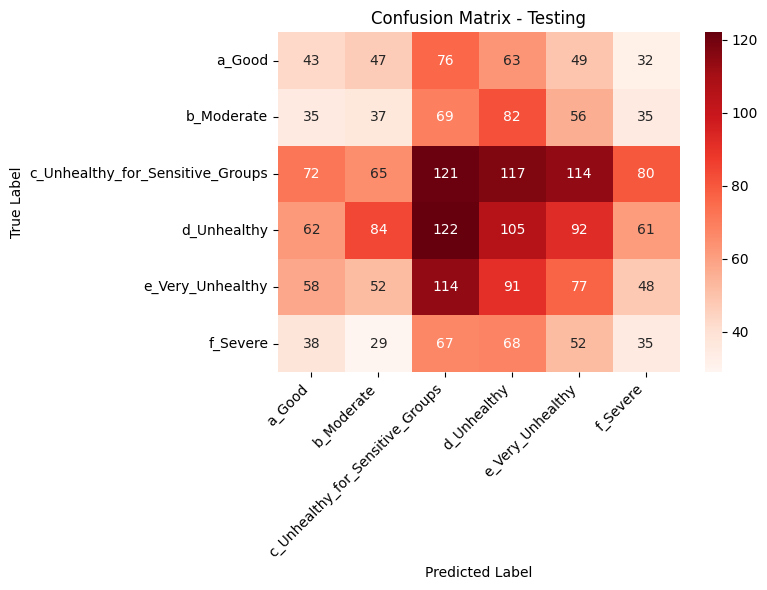

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrices
train_cm = confusion_matrix(train_generator.classes, train_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred)

# Define class labels
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap='Greens', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()
